# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 37

**Author 1 (sciper):** Elias De Smijter (366670)  
**Author 2 (sciper):** Félicie Alice Agnès Marie Giraud-Sauveur (284220)   
**Author 3 (sciper):** Cyril Felix Monette (299554)

**Release date:** 24.03.2023  
**Due date:** 07.04.2023 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library. In the `lab-02-data` folder, you will find 28x28 grey-scale pictures of handwritten "0", "1", "2" and "3".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [256]:
# Imports

import tarfile
import os

import numpy as np
from math import sqrt
import random

import skimage.io
from skimage.filters import median
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, square, erosion
from skimage.measure import inertia_tensor_eigvals

from scipy.signal import wiener
from scipy import interpolate
import scipy

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [257]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

### 0.1.Data visualization

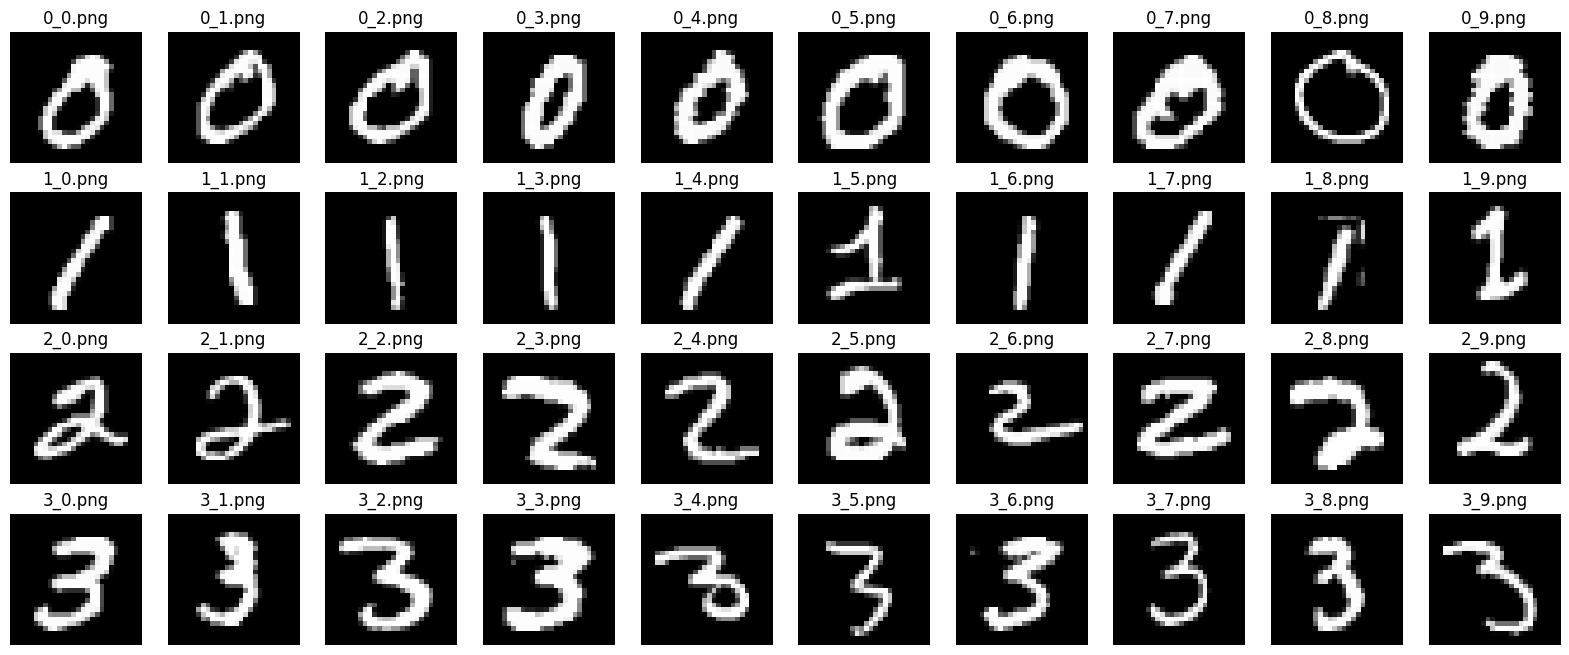

In [258]:
def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
# Load digits data

# Zero images arrays
zeros_im, zeros_names = load(data_part1, digit='0')
# Ones images arrays
ones_im, ones_names = load(data_part1, digit='1')
# Twos images arrays
twos_im, twos_names = load(data_part2, digit='2')
# Threes images arrays
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 8))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

---
## Part 1 - contour based descriptors (18 pts)

In this part you will use images of "0"s and "1"s.

**Objectives overview**: Fourier Descriptors


**1)** *Preprocess*: Select ONLY "0" and "1" images and apply suitable preprocessing. Show a plot with the preprocessed data and give arguments on the chosen techniques. (**2 pts**)


**2)** *Get descriptors*: Find the contours and get the Fourier descriptors in complex definition. *Note*: The contours arrays should contain a finite number (N-> self-chosen) of equi-distant points for each image (hint: interpolation). In the case of the "0" contours, just keep the outermost contour. Discuss the necessity of this format. (**4 pts**)
    
    
**3)** *Study effect of descriptors* : Show the contour-reconstruction of the digits using different amount of descriptors (both for ONE "0" image and ONE "1" image)
- Make 5 plots, reconstructing the digits' countours using different amounts of descriptors. (e.g. reconstruct the contour using the only the 1st fourier descriptor, reconstruct using the first two fourier descriptors,  using the first three ...)  
- **Hint**: check scipy fft, ifft, and fftfreq functions (see [link](https://docs.scipy.org/doc/scipy/tutorial/fft.html)) and pay attention on the ordering, observing which coefficients correspond to positive/negative frequencies of components and how you choose your low frequency subsets . 
- **Extra hint** To reconstruct the contour, copy the original vector of the fourier descriptors, keep the positive an negative frequencies you will use, and set to 0 the rest. (e.g. If you want to reconstruc the image with the first _three fourier descriptors_, keep the first _three positive frecuencies_ and their respective _three negative frequencies_ (see positive and negative bin freque
    frequencies [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ). 
- Discuss about your findings. (**4 pts**)
    
        
**4)** *Clustering*: For each image containing a "0" or a "1", using the fourier descriptors, extract a 2-dimensional feature vector (using the THE POSITIVE bin frequencies from fftfreq, see [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) ) and plot all of them on a 2D graph. Did you obtain a plot where the vectors of the "0"'s nicely cluster in one part of the plane and those of the "1"'s in the other? If yes, explain why. (**2 pts**)
    
    
**5)** *Show translation, rotation and scale invariance*
- Firstly, discuss which descriptors, or which part of the descriptors are affected by each transformation. For each transformation define (write in words) an operation which will be applied to the descriptor arrays, such that they will be invariant to (not affected by) the specific transformation anymore. After finding the necessary operations, define a function that will make the Fourier descriptors invariant to all the transformations, altogether.(**3 pts**) 
- Secondly, show that if you are using descriptors invariant to transformations, you still obtain 2 nicely defined clusters for the 2 categories of numbers, under transformations applied. (You need to define custom functions for each transformation, apply them on images, and compare the obtained invariant descriptors). Discuss your findings. (**3 pts**)

### 1. Fourier Descriptors

### 1.1. Preprocess and visualization (2 pts)

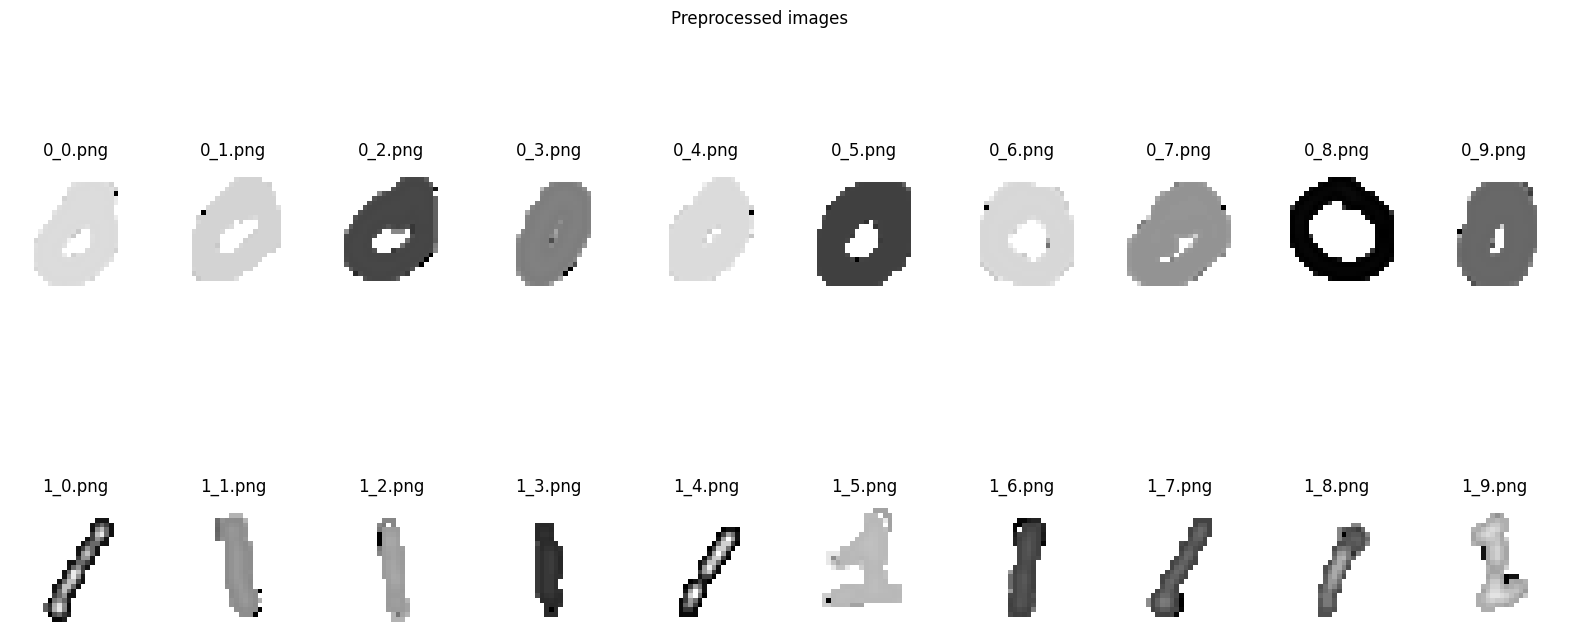

In [259]:
# Pre-processing

    # lists to fill with the preprocessed images of "0"s and "1"s
zeros = []
ones = []

    # pre-process, fill lists and plot

fig, axes = plt.subplots(2, len(zeros_im), figsize=(20, 8))

# For zeros
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im_preprocessed = wiener(median(im.copy()),3)
    zeros.append(im_preprocessed)
    ax.imshow(im_preprocessed, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# For ones
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im_preprocessed = wiener(remove_small_objects(cv2.convertScaleAbs(median(im.copy())), min_size=3), 3)
    ones.append(im_preprocessed)
    ax.imshow(im_preprocessed, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

fig.suptitle("Preprocessed images")
plt.show()

#### Discussion:

- **For the zeros: We first applied a median filter. This filter allows to remove the spiky noise around the numbers and sometimes near the edges. This filter also has the advantage of preserves sharp edges, which is interesting here. We then applied a Wiener filter. This type of filter was chosen because it allows to accentuate the contours, which will be useful for the following, but taking into account the noise to avoid amplifying it too.**

- **For the ones: We used the same procedure as for the zeros but added a "removed small objects" step between the median and the wiener filtering. The main reason for this is image 1_8.png where there are some artifacts around the written one that this extra step removes.**

### 1.2. Get descriptors (4 pts)

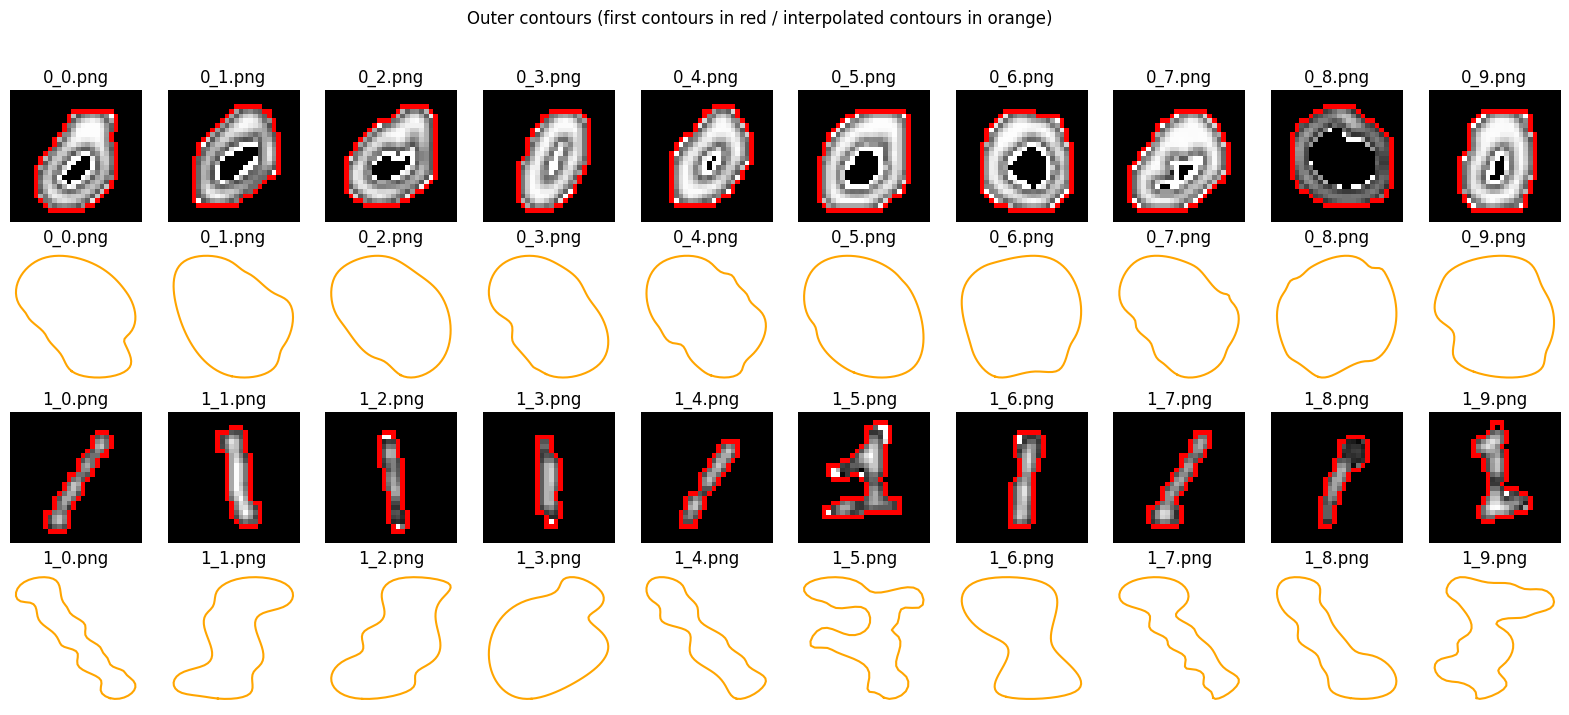

In [260]:
# Find contours, fill lists and plot
# For zeros, we just keep the outermost contour
# We also use interpolation on the contours

fig, axes = plt.subplots(4, len(zeros), figsize=(20, 8))


# For zeros
for ax0, ax1, im, nm in zip(axes[0], axes[1], zeros, zeros_names):
    
    # find contours
    im_contours = im.copy()
    im_contours = cv2.convertScaleAbs(im_contours)
    Co, _ = cv2.findContours(im_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    im_contours = cv2.cvtColor(im_contours, cv2.COLOR_GRAY2BGR)
    
    # interpolate contours
    xco = Co[0].T[0][0]
    yco = Co[0].T[1][0]
    data = np.array(list(zip(xco, yco)))
    tck,u = interpolate.splprep(data.transpose(), s=1, per=1)
    unew = np.linspace(0, 1, 100)
    out = interpolate.splev(unew, tck)
    
    # show contours
    ax0.imshow(cv2.drawContours(im_contours, Co, -1, (255, 0, 0), 1))
    ax1.plot(out[0], out[1], color='orange')  
    ax0.axis('off')
    ax0.set_title(nm)
    ax1.axis('off')
    ax1.set_title(nm)

    
# For ones
for ax0, ax1, im, nm in zip(axes[2], axes[3], ones, ones_names):
    
    # find contours
    im_contours = im.copy()
    im_contours = cv2.convertScaleAbs(im_contours)
    Co, _ = cv2.findContours(im_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    im_contours = cv2.cvtColor(im_contours, cv2.COLOR_GRAY2BGR)
    
    # interpolate contours
    xco = Co[0].T[0][0]
    yco = Co[0].T[1][0]
    data = np.array(list(zip(xco, yco)))
    tck,u = interpolate.splprep(data.transpose(), s=1, per=1)
    unew = np.linspace(0, 1, 100)
    out = interpolate.splev(unew, tck)
    
    # show contours
    ax0.imshow(cv2.drawContours(im_contours, Co, -1, (255, 0, 0), 1))
    ax1.plot(out[0], out[1], color='orange')
    ax0.axis('off')
    ax0.set_title(nm)
    ax1.axis('off')
    ax1.set_title(nm)

fig.suptitle("Outer contours (first contours in red / interpolated contours in orange)")
plt.show()

In [261]:
# Get the Fourier descriptors in complex definition

def get_descriptors(im):
    """Function that takes as input the image and returns a set of descriptors."""
    
    # find contours
    im_contours = im.copy()
    im_contours = cv2.convertScaleAbs(im_contours)
    Co, _ = cv2.findContours(im_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # interpolate contours
    xco = Co[0].T[0][0]
    yco = Co[0].T[1][0]
    data = np.array(list(zip(xco, yco)))
    tck,u = interpolate.splprep(data.transpose(), s=1, per=1)
    unew = np.linspace(0, 1, 100)
    out = interpolate.splev(unew, tck)
    
    # Transform coordinates to complex numbers
    fft_in = out[0] + out[1]*1.0j
    
    # Fourier transform
    descriptors = scipy.fft.fft(fft_in)
    
    return descriptors


# Check first 10 descriptors of a test image (just to check that your pipeline works well)
print(get_descriptors(ones[8])[:10])

[ 1.42256446e+03+1.39674329e+03j  2.21694159e+02-2.34072450e+02j
 -2.92084336e+01+3.59836795e+01j -1.23668404e+01-6.75659217e+00j
 -8.56708916e+00-4.60687166e+00j -6.87267748e+00+3.50356553e+00j
  2.69749309e-01+8.46558653e+00j -2.75368686e+00-1.62620568e+00j
  1.29768523e+00-3.23461028e+00j -3.08660078e+00-1.17786181e+00j]


#### Discussion:

- **Why the contours array should contain a finite number of equi-distant points for each image?**
    - The points should be equi-distant, because otherwise the 'reference-frequency' is not the same across the entire image. Example: if two pairs of points differ 5 grayscale-values, the fourier transform will assign the same frequency to both pairs because this is the only information the algorithm gets. If these pairs have different distances in the real image however (this information can't be given to the function), they should not have the same frequency! The only way to solve this, is to give equi-distant points to the algorithm.  
- **In the case of "0" contours, why only the outermost contour is kept?**
    - TODO

### 1.3. Study effect of descriptors (6 pts)

In [262]:
# Define increasing set sizes of the descriptors. You can change these numbers.
descr_set_sizes = [1, 2, 5, 10, 20]

# Define images for which you will show the recovery. You can change the id of the image.
id_zero_im = 2
id_one_im = 2

In [263]:
# Get the Fourier descriptors in complex definition for the chosen images
descriptors_zero = get_descriptors(zeros[id_zero_im])
descriptors_one = get_descriptors(ones[id_one_im])

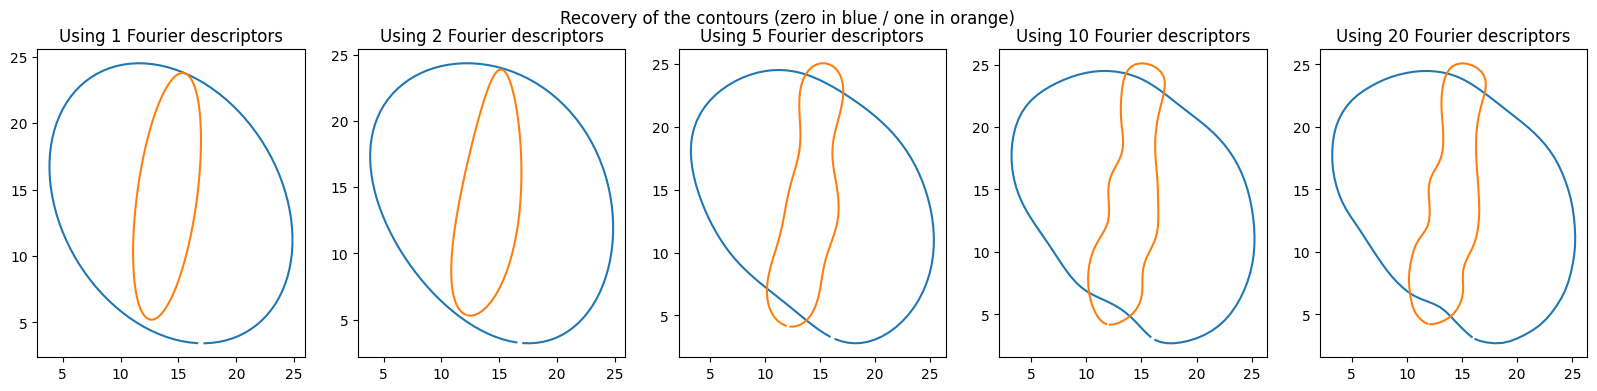

In [264]:
# Study effect of descriptors:
# On each of the 5 plots you will show the recovery of the digits' countours using different amounts of descriptors
# for the zero chosen image and for the one chosen image (using the same axis for both a "0" and a "1")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Plot recovery for a zero image
for i in range(0,  5):
    fourier = descriptors_zero.copy()
    # keep only positive and negative frequencies we want to use, and set to 0 the rest
    fourier[descr_set_sizes[i]+1:-descr_set_sizes[i]] = 0
    toplot = scipy.fft.ifft(fourier)
    xPlot = np.real(toplot)
    yPlot = np.imag(toplot)
    axes[i].plot(xPlot, yPlot)
    axes[i].set_title("Using "+str(descr_set_sizes[i])+" Fourier descriptors")

# Plot recovery for a one image
for i in range(0,  5):
    fourier = descriptors_one.copy()
    # keep only positive and negative frequencies we want to use, and set to 0 the rest
    fourier[descr_set_sizes[i]+1:-descr_set_sizes[i]] = 0
    toplot = scipy.fft.ifft(fourier)
    xPlot = np.real(toplot)
    yPlot = np.imag(toplot)
    axes[i].plot(xPlot, yPlot)
    axes[i].set_title("Using "+str(descr_set_sizes[i])+" Fourier descriptors")

fig.suptitle("Recovery of the contours (zero in blue / one in orange)")
plt.show()

#### Discussion:

**We can see that by using only the first Fourier descriptor, we find very well the general shape of the zero and the one. Moreover, taking only the very first Fourier descriptor(s) allows to have only the general shape, without the small "waves" which disturb the contours.  
And this is also the case when testing other images.**

### 1.4 Clustering (2 pts)

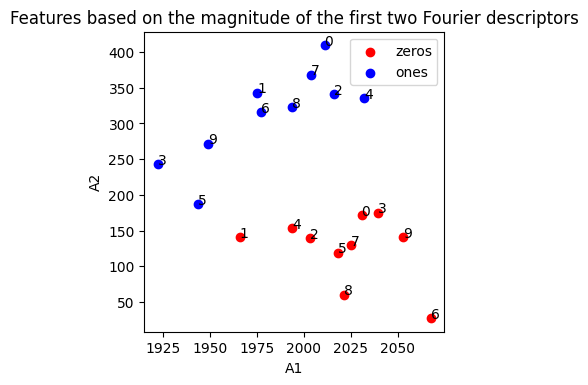

In [265]:
# Clustering: using the fourier descriptors of the zero and the one image, 
# extract a 2-dimensional feature vector (using the POSITIVE bin frequencies)
# and plot all of them on a 2D graph

# We will use the the magnitude of the first two Fourier descriptors

# First feature for all "0"s
zeros_f1 = [np.absolute(get_descriptors(im)[0]) for im in zeros]
# Second feature for all "0"s
zeros_f2 = [np.absolute(get_descriptors(im)[1]) for im in zeros]

# Fist feature for all "1"s
ones_f1 = [np.absolute(get_descriptors(im)[0]) for im in ones]
# Second feature for all "1"s
ones_f2 = [np.absolute(get_descriptors(im)[1]) for im in ones]

# Plot features for all images
fig = plt.figure(figsize=(3, 3))
ax = fig.add_axes([0,0,1,1])
ax.scatter(zeros_f1, zeros_f2, color='r', label='zeros')
ax.scatter(ones_f1, ones_f2, color='b', label='ones')
for i in range(10):
    ax.annotate(i, (zeros_f1[i], zeros_f2[i]))
for i in range(10):
    ax.annotate(i, (ones_f1[i], ones_f2[i]))
ax.legend(loc='best')
ax.set_xlabel('A1')
ax.set_ylabel('A2')
plt.title("Features based on the magnitude of the first two Fourier descriptors")
plt.show()

#### Discussion:

**We obtain a plot where the vectors of the "0"'s nicely cluster in one part of the plane and those of the "1"'s in the other. This is rather logical since we have seen previously that the first two Fourier descriptors allowed us to have the general shape and thus to distinguish well between a zero and a one.**

### 1.5 Transformation invariance (6 pts)

#### Preliminary discussion: Fourier descriptors and effect of a translation, a rotation or a scaling:

- **The translation affects the first Fourier descriptor. In order to be translation invariant, the very first Fourier descriptor must be ignored.**
- **The rotation affects the phase of the Fourier descriptors by the same amount. To be invariant to the rotation, we will take only the amplitude of each Fourier descriptor, which is not modified by the rotation.**
- **The scaling affects the Fourier descriptors by multiplying each of them by the same value. To be invariant to the scaling, we will take the ratio between Fourier descriptors.**

#### Implementation

In [266]:
# Function to be invariant in translation and/or rotation and/or scaling

def get_invariant_features(im, inv_to_translation=False, inv_to_rotation=False, inv_to_scale=False):
    """Implement a function that takes as input an image 
    and outputs a set of features invariant to scale, rotation and translation,
    according to function boolean parameters."""
    
    descriptors = get_descriptors(im)
    
    if inv_to_translation:
        # remove the first Fourier descriptor
        descriptors = descriptors[1:]
    
    if inv_to_rotation:
        # take only the amplitude of the Fourier descriptors
        descriptors = np.absolute(descriptors)
    
    if inv_to_scale:
        # take the ratio of Fourier descriptors
        descriptors = descriptors[1:]/descriptors[:-1]
        
    return np.absolute(descriptors)

In [267]:
# Define functions to apply transformations to an image


# Define translation function
def random_translate(im):
    """Translate the image"""
    transfo_im = im.copy()
    height, width = transfo_im.shape
    trnsl_height, trnsl_width = height/random.randint(2,3), width/random.randint(2,3)
    T = np.float32([[1, 0, trnsl_width], [0, 1, trnsl_height]])
    return cv2.warpAffine(transfo_im, T, (width, height))


# Define rotation function
def random_rotate(im):
    """Rotate the image"""
    transfo_im = im.copy()
    return scipy.ndimage.rotate(transfo_im, random.randint(1,359), reshape=True)


# Define scaling function
def random_scale(im):
    """Change the scale of the image"""
    transfo_im = im.copy()
    scale_percent = random.uniform(0.1,1.50)
    width = int(transfo_im.shape[1]*scale_percent)
    height = int(transfo_im.shape[0]*scale_percent)
    dim = (width, height)
    return cv2.resize(transfo_im, dim)

In [268]:
# Define 4 sets of new images with some transformations

# Apply only translation for each "0" and "1" and store results
translated_zeros = [random_translate(im) for im in zeros]
translated_ones = [random_translate(im) for im in ones]

# Apply only rotation for each "0" and "1" and store results
rotated_zeros = [random_rotate(np.nan_to_num(im, nan=0)) for im in zeros]
rotated_ones = [random_rotate(np.nan_to_num(im, nan=0)) for im in ones]

# Apply only scaling for each "0" and "1" and store results
scaled_zeros = [random_scale(im) for im in zeros]
scaled_ones = [random_scale(im) for im in ones]

# Apply all 3 transformations sequentially, in your custom order, for each "0" and "1" and store results
all_zeros = [random_scale(random_rotate(np.nan_to_num(random_translate(im), nan=0))) for im in zeros]
all_ones = [random_scale(random_rotate(np.nan_to_num(random_translate(im), nan=0))) for im in ones]

<p style="color:red"> <b> !! ATTEMPT TO DEBUG: !! </b> </p>

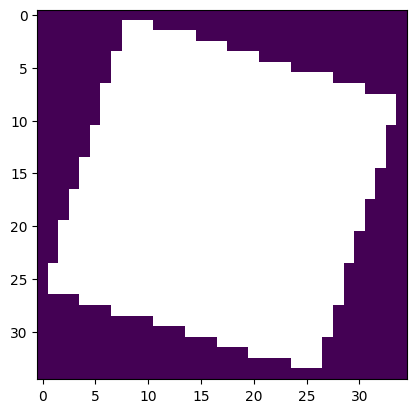

In [277]:
plt.imshow(random_rotate(np.nan_to_num(zeros[0].copy(), nan=0)))

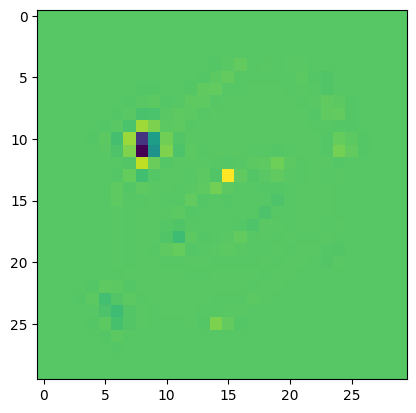

In [295]:
plt.imshow(random_rotate(np.nan_to_num(zeros[1].copy(), nan=0)))

In [ ]:
def get_descriptors(im):
    """Function that takes as input the image and returns a set of descriptors."""
    
    # find contours
    im_contours = im.copy()
    im_contours = cv2.convertScaleAbs(im_contours)
    Co, _ = cv2.findContours(im_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    try:
        print("ok")
        # interpolate contours
        xco = Co[0].T[0][0]
        yco = Co[0].T[1][0]
        data = np.array(list(zip(xco, yco)))
        tck,u = interpolate.splprep(data.transpose(), s=1, per=1, k=2)
        unew = np.linspace(0, 1, 100)
        out = interpolate.splev(unew, tck)

        # Transform coordinates to complex numbers
        fft_in = out[0] + out[1]*1.0j

        # Fourier transform
        descriptors = scipy.fft.fft(fft_in)
    except:
        plt.imshow(im)
    
    return descriptors

<p style="color:red"> <b> !! END OF DEBBUGING ZONE !! </b> </p>

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][9]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][14]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][7]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/usr/local/lib/python3.8/dist-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][11]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %


UnboundLocalError: local variable 'descriptors' referenced before assignment

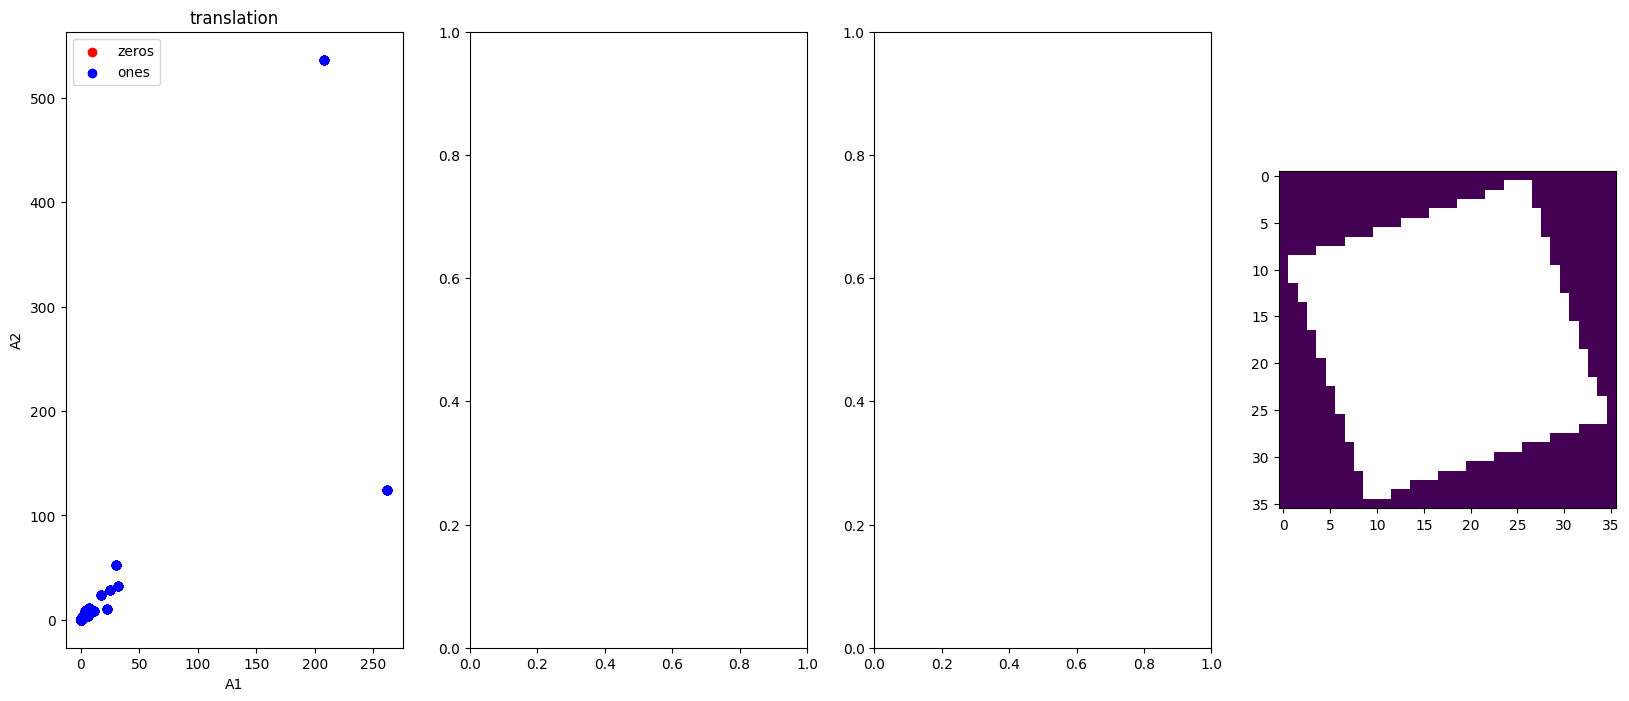

In [270]:
# For each of the 4 sets of "0"s and "1"s transformed, 
# find the invariant features and make a plot (similar to section 1.4)

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
transfo = ["translation", "rotation", "scaling", "all"]
inv_params = [(True, False, False), (False, True, False), (False, False, True), (True, True, True)]
transformed_zeros = [translated_zeros, rotated_zeros, scaled_zeros, all_zeros]
transformed_ones = [translated_ones, rotated_ones, scaled_ones, all_ones]

for i in range(4):
    
    # Get invariant images
    inv_zeros = [get_invariant_features(im, inv_params[i][0], inv_params[i][1], inv_params[i][2]) for im in transformed_zeros[i]]
    inv_ones = [get_invariant_features(im, inv_params[i][0], inv_params[i][1], inv_params[i][2]) for im in transformed_ones[i]]
    
    # First feature for all "0"s
    zeros_f1 = [inv_zeros[0] for im in inv_zeros]
    # Second feature for all "0"s
    zeros_f2 = [inv_zeros[1] for im in inv_zeros]
    
    # First feature for all "1"s
    ones_f1 = [inv_zeros[0] for im in inv_ones]
    # Second feature for all "1"s
    ones_f2 = [inv_zeros[1] for im in inv_ones]

    # Plot features for all images
    axes[i].scatter(zeros_f1, zeros_f2, color='r', label='zeros')
    axes[i].scatter(ones_f1, ones_f2, color='b', label='ones')

    axes[i].legend(loc='best')
    axes[i].set_xlabel('A1')
    axes[i].set_ylabel('A2')
    axes[i].set_title(transfo[i])

plt.title("Features based on 2 Fourier descriptors")
plt.show()

#### Discussion

TODO

## PART 2 - region based descriptors (10 pts)

In this part, you will use the "2"s and "3"s images.

**Objectives overview**:

**1)** *Cluster on compacity*: Based on custom definitions of perimeter and area for each image of "2" and "3" (preprocessed - by you), make a 2D plot with 2-dimensional feature vectors, similar to section 1.4. After that, define the compacity feature for each "2"s and "3"s image. Are you still able to obtain a 1D plot with values clustered in 2 well-defined regions? Discuss your findings. (**6 pts**).

**2)** *Additional method*: Choose one more region-based method (from the course or your own sources - internet allowed) and redo the 1D plot in section 2.1 (or 2D plot, depending on your choosing). Explain your method and your findings. (**4 pts**)

### 2.3. Cluster on compacity (6 pts)

**Pre-processing**

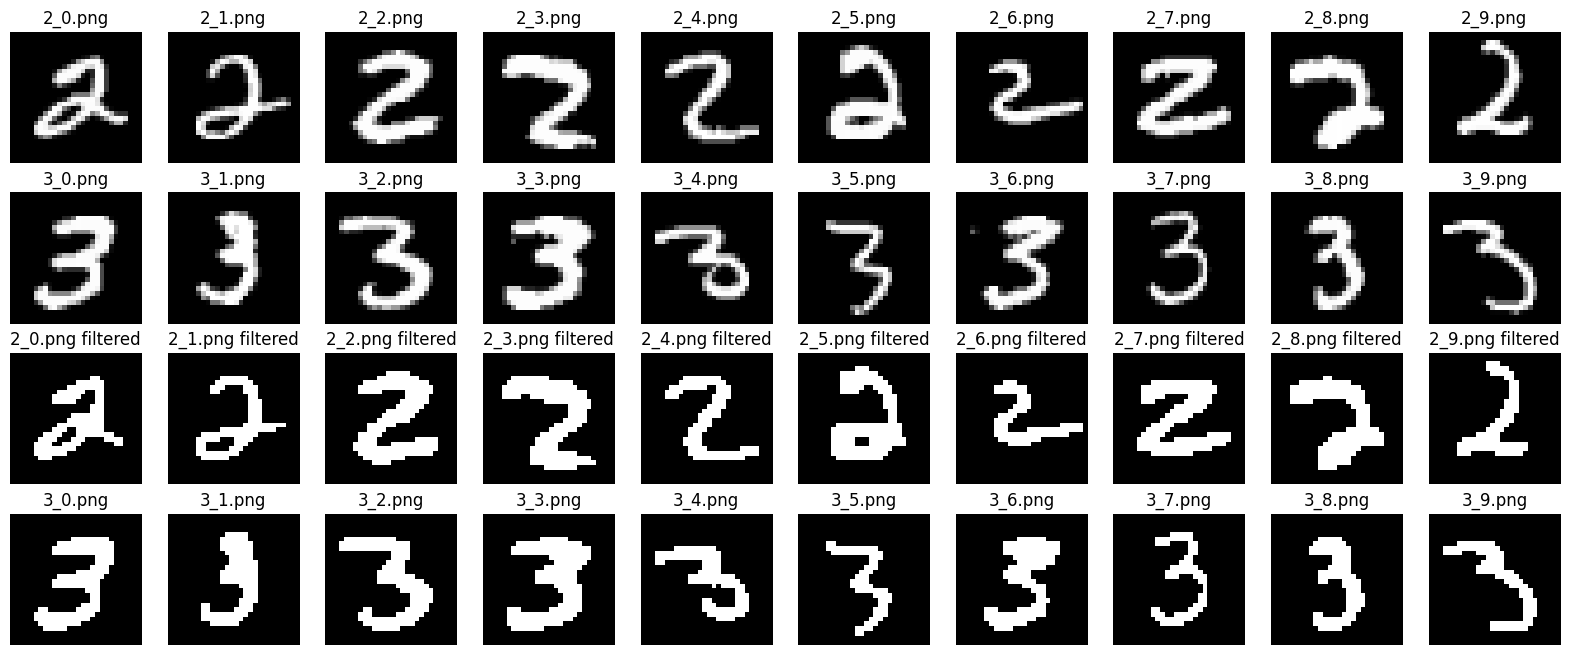

In [27]:
# TODO

# Plot original images:
fig, axes = plt.subplots(4, len(twos_im), figsize=(20, 8))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# Binarise images:
twos_im_b=np.zeros_like(twos_im)
for i,im in enumerate(twos_im):
    twos_im_b[i]=np.where(im >= 90, 1, 0)

threes_im_b=np.zeros_like(threes_im)
for i,im in enumerate(threes_im):
    threes_im_b[i]=np.where(im >= 90, 1, 0)

# median filtering:
twos_im_filtered=np.zeros_like(twos_im_b)
for i,im in enumerate(twos_im_b):
    twos_im_filtered[i]=median(im, disk(1))

threes_im_filtered=np.zeros_like(threes_im_b)
for i,im in enumerate(threes_im_b):
    threes_im_filtered[i]=median(im, disk(1))

# Plot filtered images:
for ax, im, nm in zip(axes[2], twos_im_filtered, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm+" filtered")
for ax, im, nm in zip(axes[3], threes_im_filtered, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

plt.show()

**Contour extraction**

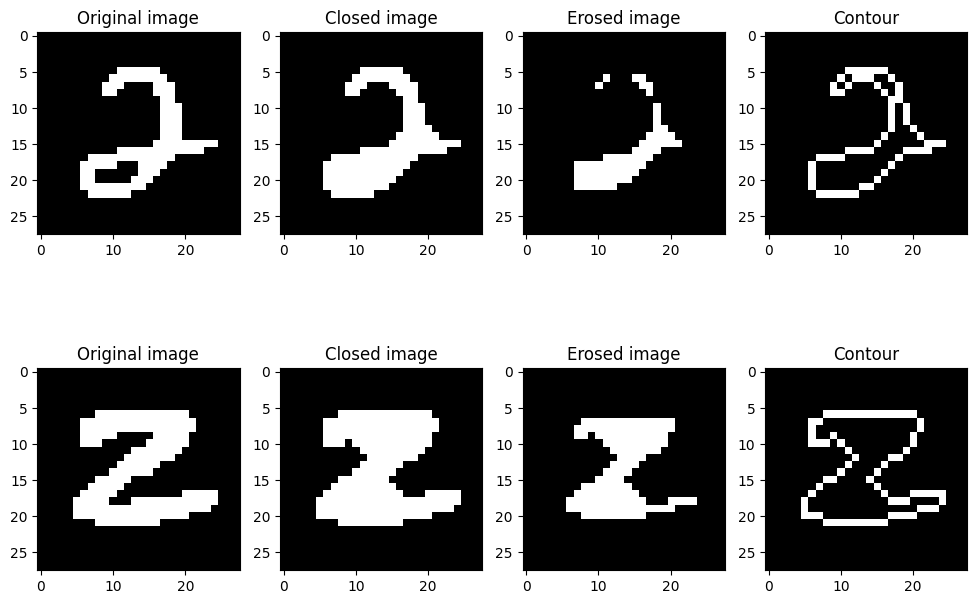

In [29]:
# First try a custom contour extraction

sample_images=[twos_im_filtered[1],twos_im_filtered[7]]

fig,axes=plt.subplots(2,4,figsize=(12,8))
for i,im in enumerate(sample_images):
    axes[i,0].imshow(im, cmap='gray')
    axes[i,0].set_title("Original image")

    axes[i,1].imshow(closing(im,selem=disk(2)), cmap='gray')
    axes[i,1].set_title("Closed image")

    axes[i,2].imshow(erosion(closing(im,selem=disk(2))), cmap='gray')
    axes[i,2].set_title("Erosed image")

    axes[i,3].imshow(closing(im,selem=disk(2))-erosion(closing(im,selem=disk(2))), cmap='gray')
    axes[i,3].set_title("Contour")

**This way of finding contours has the disadvantage of requiring a closing before erosion to avoid having inner contours included in the final contour. However, this also impacts the outer contour by smoothing sharp angles and thus overall reducing the length of the perimeter.**

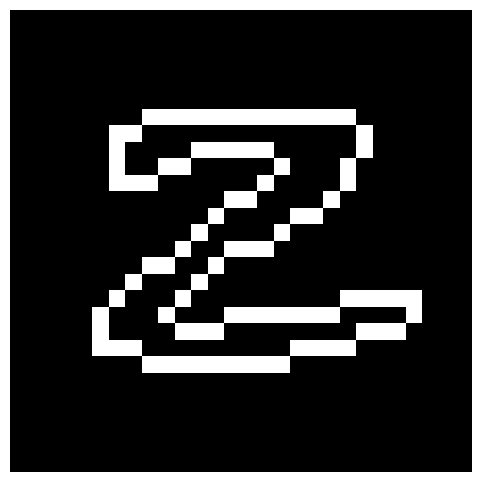

In [30]:
#Now let's try with another contour extraction process

image = np.copy(twos_im_filtered[7])
contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
border=cv2.drawContours(np.zeros_like(image), contours, 0, 1, 1)

fig = plt.figure(figsize=(10,6))
plt.axis('off')
plt.imshow(border, cmap='gray')  #without the code, only an array displayed in the console

In [31]:
# Perimeter and area functions

# Perimeter function using custom contour detection
def perimeter1(image):
    border=closing(image,selem=disk(2))
    border=erosion(border)
    border=closing(image,selem=disk(2))-border
    return np.sum(border)

# Perimeter function using cv2 contour detection
def perimeter2(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    border=cv2.drawContours(np.zeros_like(image), contours, 0, 1, 1)
    return np.sum(border)

def area(image):
    return np.sum(image)

In [32]:
# TODO: Fill the arrays below with the perimeter and area as features for "2"s and "3"s images
twos_f1 = [perimeter1(two_im) for two_im in twos_im_filtered]
twos_f1_bis = [perimeter2(two_im) for two_im in twos_im_filtered]
twos_f2 = [area(two_im) for two_im in twos_im_filtered]

threes_f1 = [perimeter1(three_im) for three_im in threes_im_filtered]
threes_f1_bis = [perimeter2(three_im) for three_im in threes_im_filtered]
threes_f2 = [area(three_im) for three_im in threes_im_filtered]

# Plot features for all images
fig, axes = plt.subplots(1,2, figsize=(12,10))
axes[0].scatter(twos_f1, twos_f2, color='r', label='twos')
axes[0].scatter(threes_f1, threes_f2, color='b', label='threes')
axes[0].set_xlabel("Perimeter 1")
axes[0].set_ylabel("Area")
axes[0].legend(loc='best')

axes[1].scatter(twos_f1_bis, twos_f2, color='r', label='twos')
axes[1].scatter(threes_f1_bis, threes_f2, color='b', label='threes')
axes[1].set_xlabel("Perimeter 2")
axes[1].set_ylabel("Area")
axes[1].legend(loc='best')
plt.title("Features based on perimeter and area")
plt.show()

TypeError: closing() got an unexpected keyword argument 'selem'

In [ ]:
# TODO: Make the 1D plot of the compacity

def compacity(area,perimeter):
    return perimeter*perimeter/area

twos_f1 = [perimeter(two_im) for two_im in twos_im_filtered]
twos_f2 = [area(two_im) for two_im in twos_im_filtered]
threes_f1 = [perimeter(three_im) for three_im in threes_im_filtered]
threes_f2 = [area(three_im) for three_im in threes_im_filtered]

twos_c = [compacity(area, perimeter) for perimeter, area in zip(twos_f1,twos_f2)]
threes_c = [compacity(area, perimeter) for perimeter, area in zip(threes_f1,threes_f2)]

# Plot features for all images
fig = plt.figure(figsize=(10,7))
plt.hist(twos_c, label='twos')
plt.hist(threes_c, label='threes')
plt.ylabel("Compactness")
plt.legend(loc='best')
plt.title("Compactness of 2s vs 3s")
plt.show()

####  Discussion

TODO

### 2.2. Additional method (4 pts)

In [ ]:
# Compute eigenvalues of images:
twos_eigs = [inertia_tensor_eigvals(two_im) for two_im in twos_im_filtered]
threes_eigs = [inertia_tensor_eigvals(two_im) for two_im in threes_im_filtered]

# Compute elongation of images:
twos_elongation = [sqrt(eig[0]/eig[1]) for eig in twos_eigs]
threes_elongation = [sqrt(eig[0]/eig[1]) for eig in threes_eigs]

# Plot elongation for all images
fig = plt.figure(figsize=(10,7))
plt.hist(twos_elongation, label='twos')
plt.hist(threes_elongation, label='threes')
plt.ylabel("Elongation")
plt.legend(loc='best')
plt.title("Elongation of 2s vs 3s")
plt.show()

#### Discussion

TODO